In [13]:
import numpy as np
import matplotlib.pyplot as plt
import copy

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

def generate_checkerboard_samples(N, size):
    # Initialize a tensor to hold the N samples of checkerboard patterns
    samples = torch.zeros((N, size, size, 3))  # 3 for RGB channels

    for i in range(N):
        # Generate random colors for the checkerboard
        color1 = torch.rand(3, dtype=torch.float32)  # Color for one set of squares
        color2 = torch.rand(3, dtype=torch.float32)  # Color for the other set of squares

        for x in range(size):
            for y in range(size):
                if (x + y) % 2 == 0:
                    samples[i, x, y] = color1
                else:
                    samples[i, x, y] = color2

    return samples

def visualize(matrix : np.ndarray, title : str = ""):
    if matrix.ndim == 2:  # Grayscale image
        plt.imshow(matrix, cmap='gray', interpolation='none', vmin=0, vmax=1)
    else:  # RGB image
        plt.imshow(matrix, interpolation='none', vmin=0, vmax=1)
    plt.title(title)
    plt.colorbar()
    plt.show()

def do_noise_skip(input : torch.tensor, t : int, beta_t : float):
    ret = copy.deepcopy(input)

    for i in range(t):
        ret = ret * np.sqrt(1 - beta_t) + torch.randn(input.shape) * np.sqrt(beta_t)

    # ret = torch.clamp(ret, 0, 1) # do they do this in the original paper?
    return ret

def do_fast_noise_skip(input : torch.tensor, t : int, beta_t : float):
    # might be able to get further optimized

    alpha_t_cum = 1
    for i in range(1, t+1):
        alpha_t_cum *= (1 - beta_t)

    standard_normal = torch.randn(input.shape)
    noise = standard_normal * np.sqrt(1- alpha_t_cum)

    input_with_noise = input + noise

    # input_with_noise = torch.clamp(input_with_noise, 0, 1) # do they do this in the original paper?

    return input_with_noise, standard_normal

def get_MNIST(grid_size) -> torch.tensor:
    # returns inputs, images of digits

    class FlattenTransform:
        def __call__(self, tensor):
            return tensor.view(-1)

    transform = transforms.Compose([
    transforms.Resize((grid_size, grid_size)),
    transforms.ToTensor(),
    FlattenTransform(),
    ])

    mnist_train = datasets.MNIST('mnist_data', train=True, download=True, transform=transform)

    digit_1_indices = [i for i, label in enumerate(mnist_train.targets) if label == 1]
    digit_1_images = torch.stack([mnist_train[i][0] for i in digit_1_indices])

    return digit_1_images


class MyDataset(Dataset):

    # big part of this function can be vectorized
    def __init__(self, nr_noised_img_per_img_without_noise, nr_unique_img_without_noise, beta_t, T, USE_EXISTING_DATASET=False, grid_size=None, nr_channels=None):
        self.USE_EXISTING_DATASET = USE_EXISTING_DATASET
        self.grid_size = grid_size
        self.beta_t = beta_t
        self.nr_channels = nr_channels
        self.nr_noised_img_per_img_without_noise = nr_noised_img_per_img_without_noise
        self.nr_unique_img_without_noise = nr_unique_img_without_noise

        self.nr_samples = nr_unique_img_without_noise * nr_noised_img_per_img_without_noise

        if not USE_EXISTING_DATASET:
            self.__without_noise = generate_checkerboard_samples(self.nr_samples, self.grid_size)
        else:
            assert nr_channels == None
            self.__without_noise = get_MNIST(self.grid_size)
            self.nr_channels = 1
            assert self.nr_unique_img_without_noise <= len(self.__without_noise)

        with_noise_shape = list(self.__without_noise.shape)
        with_noise_shape[0] = self.nr_samples
        self.with_noise = torch.empty(with_noise_shape)

        self.standard_normal = torch.empty(self.with_noise.shape)
        self.t_arr = torch.empty(self.nr_samples, dtype=torch.int)

        for i in range(self.nr_samples):
            self.t_arr[i] = np.random.randint(low=1, high=T) if T >= 2 else 1
            self.with_noise[i], self.standard_normal[i] = do_fast_noise_skip(self.__without_noise[i//nr_noised_img_per_img_without_noise], self.t_arr[i], beta_t)

    def __getitem__(self, idx):
        return self.with_noise[idx].view(-1), self.standard_normal[idx].view(-1)
        # return self.with_noise[idx].view(-1), self.without_noise[idx].view(-1)
        # is it non optimal to call view here every time?
    
    def get_original_img(self, dataset_idx : int):
        assert dataset_idx < self.nr_samples
        return self.__without_noise[dataset_idx//self.nr_noised_img_per_img_without_noise]

    def __len__(self):
        return len(self.with_noise)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

T = 400
my_dataset = MyDataset(USE_EXISTING_DATASET=True, T=T, beta_t=0.03, nr_unique_img_without_noise=100, nr_noised_img_per_img_without_noise=100, grid_size=16)
my_dataloader = DataLoader(my_dataset, batch_size=len(my_dataset), shuffle=True)

# assert len(my_dataset) == len(my_dataloader)

print(len(my_dataset), len(my_dataloader))

Using device: cpu
10000 1


Epoch [1/100], cost=0.16082759201526642
Epoch [11/100], cost=0.09446792304515839
Epoch [21/100], cost=0.08354879170656204
Epoch [31/100], cost=0.07678710669279099
Epoch [41/100], cost=0.07213375717401505
Epoch [51/100], cost=0.06853586435317993
Epoch [61/100], cost=0.06540220975875854
Epoch [71/100], cost=0.06273692101240158
Epoch [81/100], cost=0.0605129711329937
Epoch [91/100], cost=0.05870252847671509
Training finished.


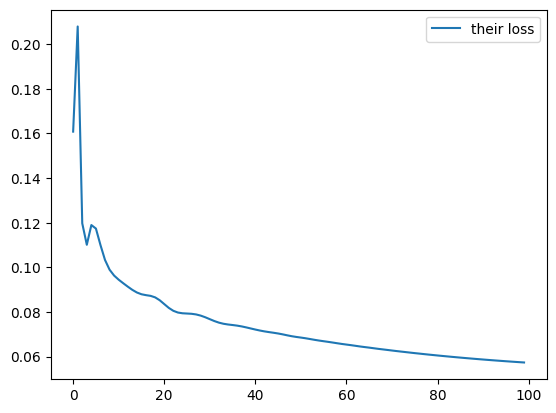

In [14]:
class DiffusionModel(nn.Module):
    def __init__(self):
        super(DiffusionModel, self).__init__()
        gs = my_dataset.grid_size
        nc = my_dataset.nr_channels
        
        nr_hidden = 3*nc if not my_dataset.USE_EXISTING_DATASET else 800
        self.fc1 = nn.Linear(in_features=gs*gs*nc, out_features=nr_hidden)

        self.sigmoid1 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=nr_hidden, out_features=gs*gs*nc)

    def forward(self, x):
        output = self.fc1(x)
        output = self.sigmoid1(output)
        output = self.fc2(output)

        output += x

        return output


model = DiffusionModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

num_epochs = 100

cost_arr = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for with_noise, standard_normal in my_dataloader:
        # TODO: put all data on GPU at once
        with_noise, standard_normal = with_noise.to(device), standard_normal.to(device)

        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(with_noise)

        loss = criterion(outputs, standard_normal)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    if epoch % (num_epochs // 10) == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], cost={running_loss}')

    cost_arr.append(loss.item())

print('Training finished.')

plt.plot(cost_arr, label='their loss')
plt.legend()
plt.show()

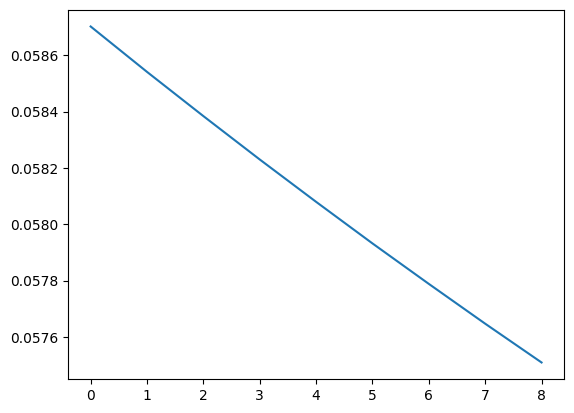

In [15]:
plt.plot(cost_arr[int(len(cost_arr)*0.9):-1])

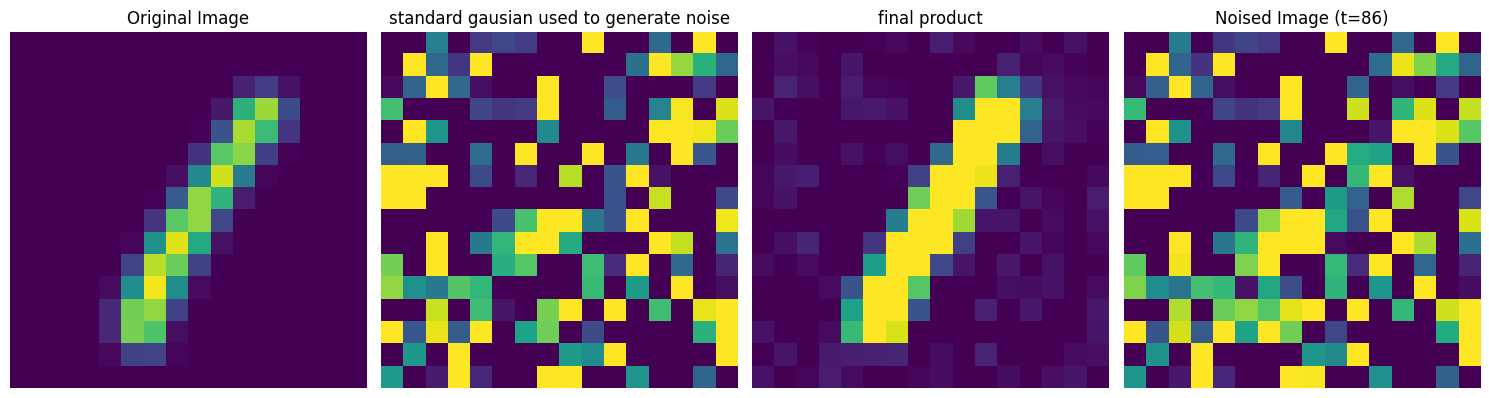

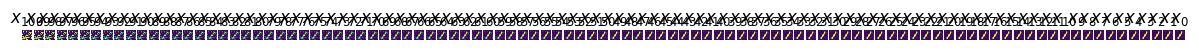

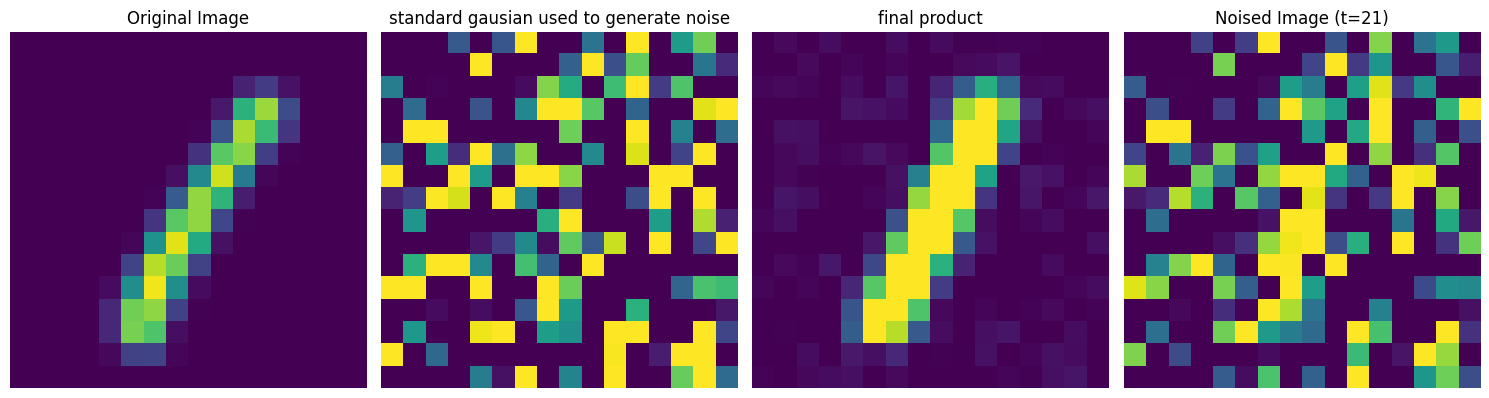

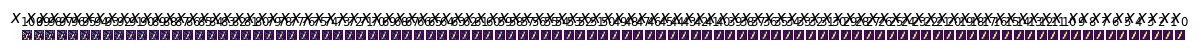

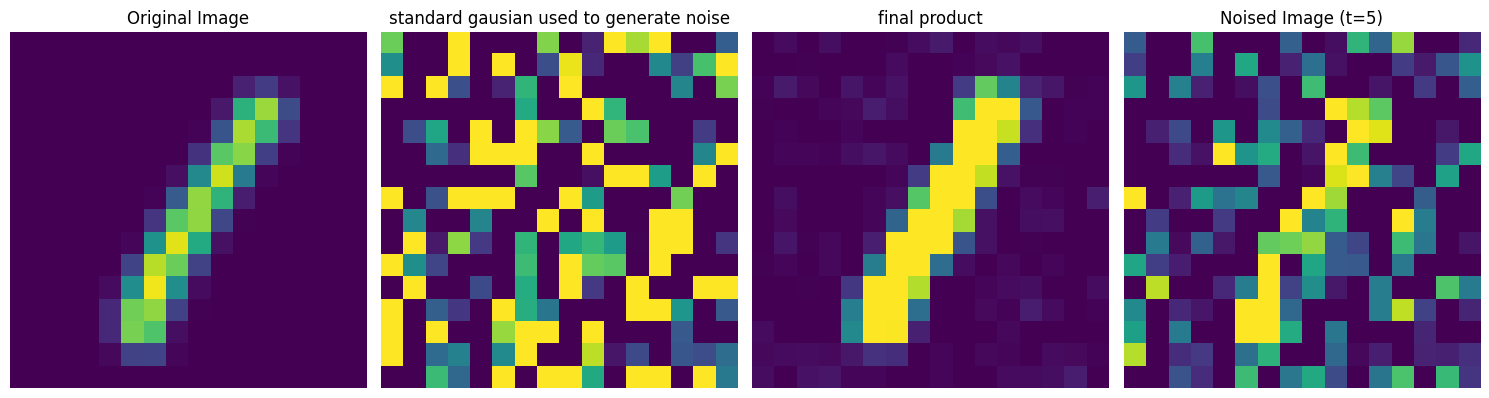

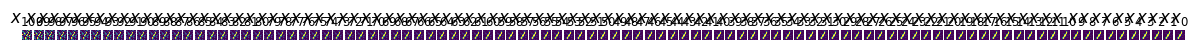

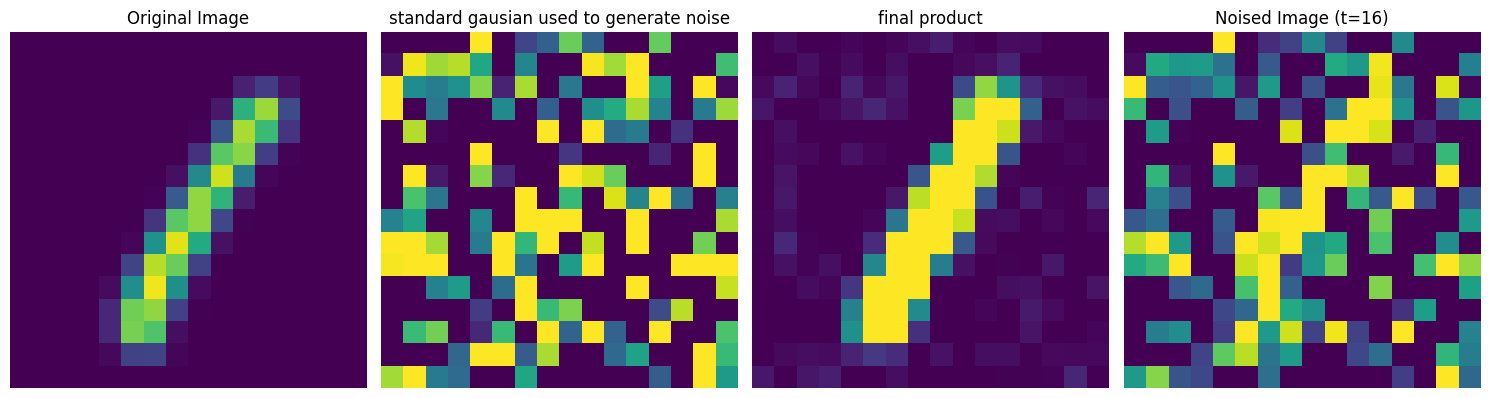

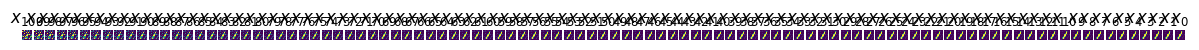

In [16]:
def get_beta_t(t : int):
    return my_dataset.beta_t # temp

def do_inference(noised_input : torch.tensor, T, model, return_denoise_intermediates=False):

    img = copy.deepcopy(noised_input)
    alpha_t_cum = 1

    if return_denoise_intermediates:
        intermediates_arr = []
        intermediates_arr.append(copy.deepcopy(img))

    model.eval()

    with torch.no_grad():
        for t in range(T):
            alpha_t = 1 - get_beta_t(t)
            alpha_t_cum *= alpha_t

            c = (1 - alpha_t) / np.sqrt(1 - alpha_t_cum)
            # random = torch.randn(img.shape) * get_beta_t(t)/20 # temp
            random = 0 # temp
            img = 1/np.sqrt(alpha_t) * (img - model(img) * c) + random

            if return_denoise_intermediates:
                intermediates_arr.append(copy.deepcopy(img))

    
    model.train()

    if return_denoise_intermediates is False:
        return img
    else:
        return img, intermediates_arr

def visualize_inference(dataset, model, T, sample_indices):
    if sample_indices == -1:
        sample_indices = [i for i in range(len(dataset))]

    for i in sample_indices:
        input_with_noise, standard_gausian = my_dataset[i]
        original_img = my_dataset.get_original_img(i)
        time_step = my_dataset.t_arr[i]

        # Perform inference
        inferred_img, intermediates_arr = do_inference(input_with_noise, T, model, return_denoise_intermediates=True)

        # Plot the images
        fig, axes = plt.subplots(1, 4, figsize=(15, 5))

        gs, nc = my_dataset.grid_size, my_dataset.nr_channels
        
        axes[0].imshow(original_img.view(gs, gs, nc), vmin=0, vmax=1, interpolation='none')
        axes[0].set_title('Original Image')
        axes[0].axis('off')

        axes[1].imshow(standard_gausian.view(gs, gs, nc), vmin=0, vmax=1, interpolation='none')
        axes[1].set_title('standard gausian used to generate noise')
        axes[1].axis('off')
        
        axes[2].imshow(intermediates_arr[-1].view(gs, gs, nc), vmin=0, vmax=1, interpolation='none')
        axes[2].set_title(f'final product')
        axes[2].axis('off')

        axes[3].imshow(input_with_noise.view(gs, gs, nc), vmin=0, vmax=1, interpolation='none')
        axes[3].set_title(f'Noised Image (t={time_step})')
        axes[3].axis('off')


        plt.tight_layout()
        plt.show()

        fig, axes = plt.subplots(1, len(intermediates_arr), figsize=(15, 5))
        for i, denoised_intermediate in enumerate(intermediates_arr):
            axes[i].imshow(denoised_intermediate.view(gs, gs, nc), vmin=0, vmax=1, interpolation='none')

            axes[i].set_title(r'$x_{'+str(T-i)+r'}$')

            axes[i].axis('off')

        for i in range(4):
            print()


# Example usage
visualize_inference(my_dataset, model, T=T, sample_indices=[0,1,2,3])